# AnomalyBERT: Synthetic Dataset vs Inferred Anomalies

This notebook loads a trained model and a synthetic dataset, runs anomaly detection, and visualizes the comparison between ground-truth labels and predicted anomaly scores.

In [37]:
# Parameters - adjust these paths
MODEL_PATH = "../models/model.pt"
DATASET_PATH = "../data/synthetic_eval/trend_shift_100.csv"
TOP_N = 10

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from anomalybert.inference.detector import AnomalyDetector

In [39]:
# Load dataset
df = pd.read_csv(DATASET_PATH)
print(f"Dataset: {len(df)} samples, {df['anomaly_tag'].sum()} ground-truth anomalies")
df.head()

Dataset: 100 samples, 1 ground-truth anomalies


,timestamp,value,probability,anomaly_tag
0,1001006405,2.249642,0.0,0
1,1001006406,2.502798,0.0,0
2,1001006407,2.187522,0.0,0
3,1001006408,2.245732,0.0,0
4,1001006409,2.149750,0.0,0


In [40]:
# Run inference
detector = AnomalyDetector(MODEL_PATH)
results = detector.detect(
    timestamps=df["timestamp"].values,
    values=df["value"].values.astype(np.float64),
    top_n=TOP_N,
)

# Also get full per-timestamp scores for visualization
normalizer = detector.normalizer
tokenizer = detector.tokenizer
norm_values = normalizer.transform(df["value"].values.astype(np.float64)) if normalizer else df["value"].values.astype(np.float32)
idx_timestamps = np.arange(len(df), dtype=np.int64)
windows = tokenizer.tokenize(idx_timestamps, norm_values)

import torch
window_scores = []
with torch.no_grad():
    for w in windows:
        input_tensor = torch.tensor(w["values"], dtype=torch.float32).unsqueeze(0)
        scores = detector.model(input_tensor)
        window_scores.append(scores.squeeze(0).numpy())

all_scores = tokenizer.aggregate_scores_simple(window_scores, total_len=len(df))
df["predicted_score"] = all_scores

print(f"Top {TOP_N} anomalies detected:")
for i, r in enumerate(results, 1):
    print(f"  {i}. timestamp={r['timestamp']}, value={r['value']:.4f}, score={r['score']:.4f}")

Top 10 anomalies detected:
  1. timestamp=1001006450, value=7.3701, score=0.1456
  2. timestamp=1001006454, value=7.5729, score=0.1437
  3. timestamp=1001006449, value=7.2575, score=0.1371
  4. timestamp=1001006455, value=7.4784, score=0.1263
  5. timestamp=1001006459, value=7.6538, score=0.1176
  6. timestamp=1001006451, value=7.1608, score=0.1165
  7. timestamp=1001006452, value=7.1340, score=0.1083
  8. timestamp=1001006461, value=7.6924, score=0.1070
  9. timestamp=1001006458, value=7.3821, score=0.0987
  10. timestamp=1001006464, value=7.6832, score=0.0907


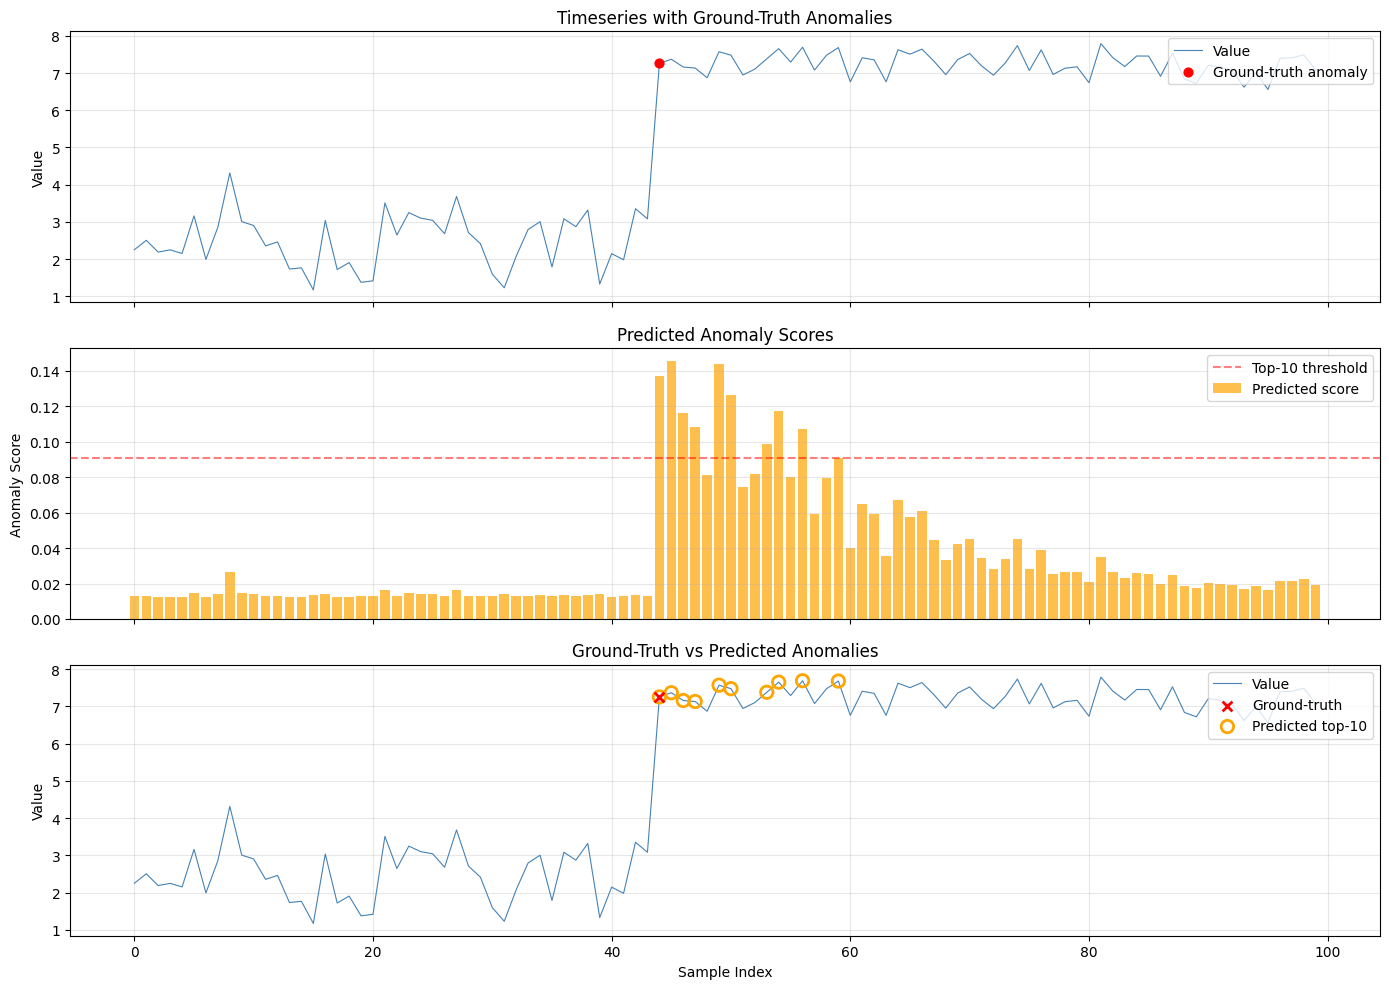

In [41]:
# Visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

x = np.arange(len(df))

# Panel 1: Timeseries with ground-truth anomalies highlighted
ax = axes[0]
ax.plot(x, df["value"], color="steelblue", linewidth=0.8, label="Value")
anomaly_mask = df["anomaly_tag"] == 1
ax.scatter(x[anomaly_mask], df["value"][anomaly_mask], color="red", s=40, zorder=5, label="Ground-truth anomaly")
ax.set_ylabel("Value")
ax.set_title("Timeseries with Ground-Truth Anomalies")
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)

# Panel 2: Predicted anomaly scores
ax = axes[1]
ax.bar(x, df["predicted_score"], color="orange", alpha=0.7, label="Predicted score")
ax.axhline(y=np.sort(all_scores)[-TOP_N] if len(all_scores) >= TOP_N else 0, color="red", linestyle="--", alpha=0.5, label=f"Top-{TOP_N} threshold")
ax.set_ylabel("Anomaly Score")
ax.set_title("Predicted Anomaly Scores")
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)

# Panel 3: Comparison overlay
ax = axes[2]
ax.plot(x, df["value"], color="steelblue", linewidth=0.8, label="Value")
ax.scatter(x[anomaly_mask], df["value"][anomaly_mask], color="red", s=50, zorder=5, marker="x", linewidths=2, label="Ground-truth")
top_n_timestamps = {r["timestamp"] for r in results}
predicted_mask = df["timestamp"].isin(top_n_timestamps)
ax.scatter(x[predicted_mask], df["value"][predicted_mask], color="orange", s=80, zorder=4, facecolors="none", edgecolors="orange", linewidths=2, label=f"Predicted top-{TOP_N}")
ax.set_xlabel("Sample Index")
ax.set_ylabel("Value")
ax.set_title("Ground-Truth vs Predicted Anomalies")
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [42]:
# Summary statistics
gt_anomaly_indices = set(df.index[anomaly_mask])
predicted_indices = set(df.index[predicted_mask])
overlap = gt_anomaly_indices & predicted_indices

print(f"Ground-truth anomalies: {len(gt_anomaly_indices)}")
print(f"Predicted top-{TOP_N}:    {len(predicted_indices)}")
print(f"Overlap (true positives): {len(overlap)}")
if len(predicted_indices) > 0:
    precision = len(overlap) / len(predicted_indices)
    print(f"Precision: {precision:.2%}")
if len(gt_anomaly_indices) > 0:
    recall = len(overlap) / len(gt_anomaly_indices)
    print(f"Recall:    {recall:.2%}")

Ground-truth anomalies: 1
Predicted top-10:    10
Overlap (true positives): 1
Precision: 10.00%
Recall:    100.00%
